
# UA Innovate Data Analytics Challenge - Data Scientist Track


## Exploratory Data Analysis
Exploratory Data Analysis is used to initially look into the data. We can see what types of data we are working with, plot correlations of features to the predicted variable to see if they may be good predictors, and see how we may want to deal with missing data.


In [51]:
#import essential packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pandas_profiling import ProfileReport

#read in dataset and see overview of data
train_df = pd.read_csv("train.csv")
print("There are {} rows and {} columns".format(train_df.shape[0], train_df.shape[1]))
print(train_df.dtypes.value_counts())
train_df.head()

There are 75757 rows and 64 columns
int64      37
float64    24
object      3
dtype: int64


,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4


We can now see the first five rows of the dataset, how many rows and columns there are, and how many of each type we have: 37 int, 24 float, and 3 categorical.
Next, we will look at any data we might be missing.

In [9]:
#splitting categorical and numerical data
cat_vars = train_df.columns[train_df.dtypes == 'object']
num_vars = train_df.columns[train_df.dtypes != 'object']
#find categorical missing data
train_df[cat_vars].isnull().sum()

State_Factor      0
building_class    0
facility_type     0
dtype: int64

There is no missing categorical data.
Now let's look at numerical data.

In [10]:
#find numerical missing data
train_df[num_vars].isnull().sum().sort_values(ascending = False) / len(train_df)

days_with_fog                0.604512
direction_peak_wind_speed    0.551909
max_wind_speed               0.542287
direction_max_wind_speed     0.542287
energy_star_rating           0.352561
                               ...   
august_min_temp              0.000000
august_avg_temp              0.000000
august_max_temp              0.000000
september_min_temp           0.000000
id                           0.000000
Length: 61, dtype: float64

We now can see some of the data we are missing. We are missing 60% of fog data, ~55% of wind speed varibles data and 35% of energy_star_rating. We may think about throwing this data out, however, what if this data happens to be a great predictor? That's why next we will analyze correlation between variables to see if a feature could be a good predictor. 

Let's take a look at our target variable's distribution.

C:\Users\betha\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


996.864950898


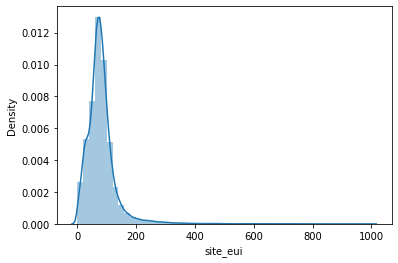

In [54]:
sns.distplot(train_df['site_eui'])
#find range
rnge = train_df['site_eui'].max() - train_df['site_eui'].min()
print(rnge)

We can also look at distributions of single variables

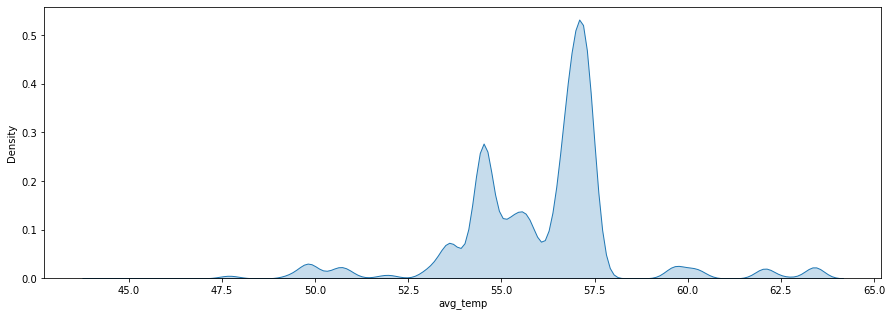

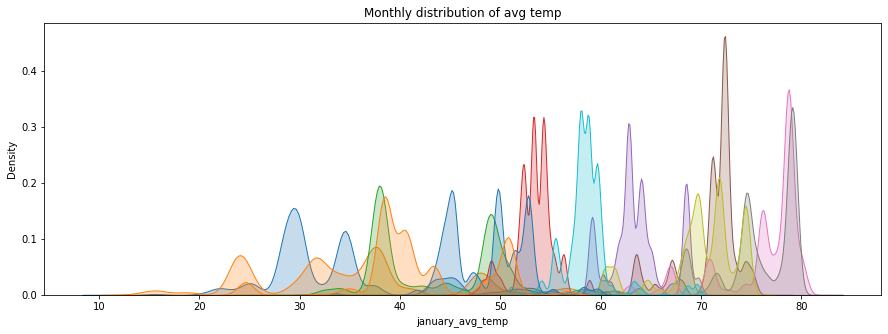

In [44]:
plt.figure(figsize=(15, 5))
sns.kdeplot(train_df['avg_temp'], shade=True)
plt.figure(figsize=(15, 5))
avg_temp=['january_avg_temp', 'february_avg_temp','march_avg_temp','april_avg_temp','may_avg_temp','june_avg_temp','july_avg_temp','august_avg_temp','september_avg_temp', 'october_avg_temp','november_avg_temp', 'december_avg_temp']
for col in avg_temp:
    sns.kdeplot(train_df[col], shade=True)
    plt.title("Monthly distribution of avg temp")

<AxesSubplot:>

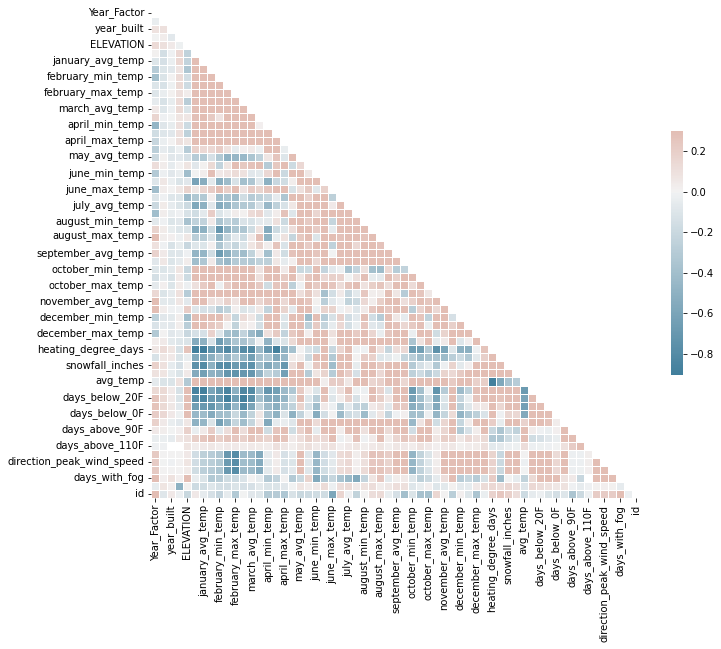

In [12]:


# Compute the correlation matrix
corr = train_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In the second to last row, between "days_with_fog" and "id", is "site_eui", our predicted variable. The closer the blocks are to the dark blue color, the higher correlation it has with our goal variable - and the more useful to our model. We can also see that some variables that have high rates of missing data have very little correlation to our goal parameter, so we can exclude those from our model. One feature that has obvious high correlation is "energy_star_rating". This feature is missing 35% of data though, so we need to handle those missing values. We will drop the missing values, still leaving us with ~50,000 observations to train our model on.

Another thing we can observe is that a lot of our input variables have correlation with each other. Features that have dependency on each other can introduce bias into our model. Therefore, we will exclude some of these redundant input varibles from our model. For example, snowfall inches or days under 10F have a high correlation with the january temperature data. The information about snowfall or days under 10F is given through the avg temp data, and instead of adding some new information, these variables cause more bias.


In [6]:
#performing Exploratory Data Analysis (EDA) with one line of code -- trying something new!

#EDA = ProfileReport(train_df)
#EDA.to_file(output_file='output.html')

#findings: it takes a long time

In [13]:
#drop rows with NaN values in 'energy_star_rating' 
train_df = train_df[train_df['energy_star_rating'].notna()]
#train_df['energy_star_rating'].isnull().sum()

#export cleaned data to csv

train_df.to_csv('clean_train.csv')

## Manual Model Building

In [49]:
#split target variable
y = train_df['site_eui']
#drop redundant variables
X = train_df.drop(columns=['State_Factor', 'building_class', 'facility_type','site_eui', 'heating_degree_days', 'precipitation_inches', 'snowfall_inches', 'snowdepth_inches', 'days_below_30F', 'days_below_20F', 'days_below_10F', 'direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed','days_with_fog'])

#split training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 50)

import xgboost
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#build model
xgb = xgboost.XGBRegressor(objective = 'reg:squarederror', 
              learning_rate = .01, 
              max_depth =  5,
              min_child_weight = 4,
              subsample = 0.7,
              colsample_bytree = 0.4,
              n_estimators =  500,
              seed = 42)
#fit model                          
xgb.fit(X_train, y_train, eval_metric='rmse', early_stopping_rounds=5, eval_set=[(X_test, y_test)])   

# make predictions
predictions = xgb.predict(X_test)


rmse = np.sqrt(mean_squared_error(y_test, predictions))
print()
print("RMSE: %f" % (rmse))



[0]	validation_0-rmse:97.04733
[1]	validation_0-rmse:96.28882
[2]	validation_0-rmse:95.62357
[3]	validation_0-rmse:94.96999
[4]	validation_0-rmse:94.23444
[5]	validation_0-rmse:93.59477
[6]	validation_0-rmse:92.87627
[7]	validation_0-rmse:92.16634
[8]	validation_0-rmse:91.54814
[9]	validation_0-rmse:90.85687
[10]	validation_0-rmse:90.25759
[11]	validation_0-rmse:89.65957
[12]	validation_0-rmse:88.99423
[13]	validation_0-rmse:88.33580
[14]	validation_0-rmse:87.68364
[15]	validation_0-rmse:87.04531
[16]	validation_0-rmse:86.48692
[17]	validation_0-rmse:85.93978
[18]	validation_0-rmse:85.32225
[19]	validation_0-rmse:84.70877
[20]	validation_0-rmse:84.17621
[21]	validation_0-rmse:83.57768
[22]	validation_0-rmse:82.98059
[23]	validation_0-rmse:82.46945
[24]	validation_0-rmse:81.89284
[25]	validation_0-rmse:81.32145
[26]	validation_0-rmse:80.83382
[27]	validation_0-rmse:80.35272
[28]	validation_0-rmse:79.80472
[29]	validation_0-rmse:79.33636
[30]	validation_0-rmse:78.80035
[31]	validation_0-

[252]	validation_0-rmse:45.42904
[253]	validation_0-rmse:45.41285
[254]	validation_0-rmse:45.39933
[255]	validation_0-rmse:45.38928
[256]	validation_0-rmse:45.37701
[257]	validation_0-rmse:45.36591
[258]	validation_0-rmse:45.32757
[259]	validation_0-rmse:45.29330
[260]	validation_0-rmse:45.25422
[261]	validation_0-rmse:45.24374
[262]	validation_0-rmse:45.21495
[263]	validation_0-rmse:45.20465
[264]	validation_0-rmse:45.19569
[265]	validation_0-rmse:45.18690
[266]	validation_0-rmse:45.15802
[267]	validation_0-rmse:45.12772
[268]	validation_0-rmse:45.11796
[269]	validation_0-rmse:45.08817
[270]	validation_0-rmse:45.08035
[271]	validation_0-rmse:45.07044
[272]	validation_0-rmse:45.05634
[273]	validation_0-rmse:45.04943
[274]	validation_0-rmse:45.04281
[275]	validation_0-rmse:45.00897
[276]	validation_0-rmse:45.00078
[277]	validation_0-rmse:44.97096
[278]	validation_0-rmse:44.96262
[279]	validation_0-rmse:44.92971
[280]	validation_0-rmse:44.90081
[281]	validation_0-rmse:44.87504
[282]	vali

In [48]:
#run test data through created model to predict values
test_df = pd.read_csv('test.csv')
X = test_df.drop(columns=['State_Factor', 'building_class', 'facility_type', 'heating_degree_days', 'precipitation_inches', 'snowfall_inches', 'snowdepth_inches', 'days_below_30F', 'days_below_20F', 'days_below_10F', 'direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed','days_with_fog'])
test_predictions = xgb.predict(X)
pd.DataFrame(test_predictions)


,0
0,92.418808
1,63.593849
2,178.949524
3,90.908653
4,115.526871
...,...
9700,65.389626
9701,61.165066
9702,65.400444
9703,68.176231


The RMSE for the selected approach is ~43.5. It'd be nice to try out many different models at once -- so we tried some out on Watson Studio. You can find our best model in the zipped folder : NoRedundancy.ipynb